# Spotter Benchmark Analysis

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import classification_report

from experiments.collaborative.analysis import (
    load_dataset,
    get_gold_answer_dataset,
    MODEL_DISPLAY_NAMES,
    get_spotter_type_short,
)
from battleship.run_spotter_benchmarks import rebuild_summary_from_results

In [21]:
%config InlineBackend.figure_format = 'retina'

# set seaborn color palette
sns.set_palette("Set2")

# set seaborn style
sns.set_style("white")
sns.set_context("talk")

In [22]:
from matplotlib import font_manager

# Set the default font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# Print current font family settings
print("Current Font Settings:")
print("=" * 40)
print(f"Default font family: {plt.rcParams['font.family']}")
print(f"Sans-serif fonts: {plt.rcParams['font.sans-serif']}")
print(f"Serif fonts: {plt.rcParams['font.serif']}")
print(f"Monospace fonts: {plt.rcParams['font.monospace']}")
print(f"Cursive fonts: {plt.rcParams['font.cursive']}")
print(f"Fantasy fonts: {plt.rcParams['font.fantasy']}")

Current Font Settings:
Default font family: ['DejaVu Sans']
Sans-serif fonts: ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
Serif fonts: ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']
Monospace fonts: ['DejaVu Sans Mono', 'Bitstream Vera Sans Mono', 'Computer Modern Typewriter', 'Andale Mono', 'Nimbus Mono L', 'Courier New', 'Courier', 'Fixed', 'Terminal', 'monospace']
Cursive fonts: ['Apple Chancery', 'Textile', 'Zapf Chancery', 'Sand', 'Script MT', 'Felipa', 'Comic Neue', 'Comic Sans MS', 'cursive']
Fantasy fonts: ['Chicago', 'Charcoal', 'Impact', 'Western', 'xkcd script', 'fantasy']


In [23]:
EXPERIMENT_NAME = "battleship-final-data"
PATH_DATA = os.path.join("data", EXPERIMENT_NAME)
PATH_EXPORT = os.path.join(PATH_DATA, "export")

df_gold = load_dataset(experiment_path=PATH_DATA, use_gold=True)

                        gameID       ended  timeoutGameEnd  gameCompleted
22  01JJ2SEBPTDG0QW8S395B2NSB8  game ended            True          False
These will be kept in the dataset.


## Human results

In [24]:
gold_labels, human_labels = get_gold_answer_dataset(df_gold)
print(len(gold_labels), len(human_labels))

931 931


In [25]:
print(classification_report(y_true=gold_labels, y_pred=human_labels))

human_accuracy_baseline = classification_report(y_true=gold_labels, y_pred=human_labels, output_dict=True)["accuracy"]
print(f"Human accuracy baseline: {human_accuracy_baseline:.2%}")

              precision    recall  f1-score   support

       False       0.92      0.91      0.92       421
        True       0.93      0.94      0.93       510

    accuracy                           0.92       931
   macro avg       0.92      0.92      0.92       931
weighted avg       0.92      0.92      0.92       931

Human accuracy baseline: 92.48%


## Modeling results

In [26]:
RUN_ID = "run_2025_07_11_18_32_51"

results = rebuild_summary_from_results(os.path.join("spotter_benchmarks", RUN_ID))
df = pd.DataFrame(results)


# Add display names and categorizations for analysis
def add_display_fields(df):
    """Add display names and categorizations to the dataframe."""
    # Add spotter type categorization
    df["spotter_type_short"] = df.apply(
        lambda row: get_spotter_type_short(row["spotter_type"], row["use_cot"]), axis=1
    )
    df["spotter_type_short"] = pd.Categorical(
        df["spotter_type_short"],
        categories=["Base", "+ CoT", "+ Code", "+ CoT + Code"],
        ordered=True,
    )

    # Add model display name
    df["llm_display_name"] = df["llm"].map(lambda x: MODEL_DISPLAY_NAMES.get(x, x))

    # Sort by order in MODEL_DISPLAY_NAMES using categorical
    df["llm_display_name"] = pd.Categorical(
        df["llm_display_name"], categories=MODEL_DISPLAY_NAMES.values(), ordered=True
    )
    df = df.sort_values(by=["llm_display_name", "spotter_type_short"])

    return df


# Process the dataframe
df = add_display_fields(df)

### Completion status

In [27]:
with pd.option_context('display.max_rows', None):
    count_df = df.groupby(["llm", "spotter_type_short"], observed=False).size().to_frame(name="count")
    display(count_df)

    filtered_count_df = count_df[count_df["count"] < 948]
    if len(filtered_count_df) > 0:
        print(f"Incomplete models:")
        display(filtered_count_df)
    else:
        print("All models complete!")

count
llm                                spotter_type_short       
anthropic/claude-opus-4            Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
anthropic/claude-sonnet-4          Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
deepseek/deepseek-chat-v3-0324     Base                  948
                                   + CoT                 948
                                   + Code                  0
                                   + CoT + Code            0
deepseek/deepseek-r1-0528          Base                  948
                                   + CoT                   0
                                   + Code                  0
                                   + CoT + Code            0
google/gemini-2.5-flash            Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
google/gemini-2.5-pro              Base                  948
                                   + CoT                 948
                                   + Code                  0
                                   + CoT + Code            0
meta-llama/llama-3.1-405b-instruct Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
meta-llama/llama-3.1-70b-instruct  Base                  948
                                   + CoT                 948
                                   + Code                786
                                   + CoT + Code          948
meta-llama/llama-3.1-8b-instruct   Base                  948
                                   + CoT                 948
                                   + Code                751
                                   + CoT + Code            0
meta-llama/llama-4-maverick        Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
meta-llama/llama-4-scout           Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
openai/gpt-4.1                     Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
openai/gpt-4.1-mini                Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
openai/gpt-4.1-nano                Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
openai/gpt-4o                      Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code          948
openai/gpt-4o-mini                 Base                  948
                                   + CoT                 948
                                   + Code                948
                                   + CoT + Code            6
openai/o3                    

Incomplete models:


count
llm                               spotter_type_short       
deepseek/deepseek-chat-v3-0324    + Code                  0
                                  + CoT + Code            0
deepseek/deepseek-r1-0528         + CoT                   0
                                  + Code                  0
                                  + CoT + Code            0
google/gemini-2.5-pro             + Code                  0
                                  + CoT + Code            0
meta-llama/llama-3.1-70b-instruct + Code                786
meta-llama/llama-3.1-8b-instruct  + Code                751
                                  + CoT + Code            0
openai/gpt-4o-mini                + CoT + Code            6

In [28]:
" ".join(filtered_count_df.reset_index().llm.unique().tolist())

'deepseek/deepseek-chat-v3-0324 deepseek/deepseek-r1-0528 google/gemini-2.5-pro meta-llama/llama-3.1-70b-instruct meta-llama/llama-3.1-8b-instruct openai/gpt-4o-mini'

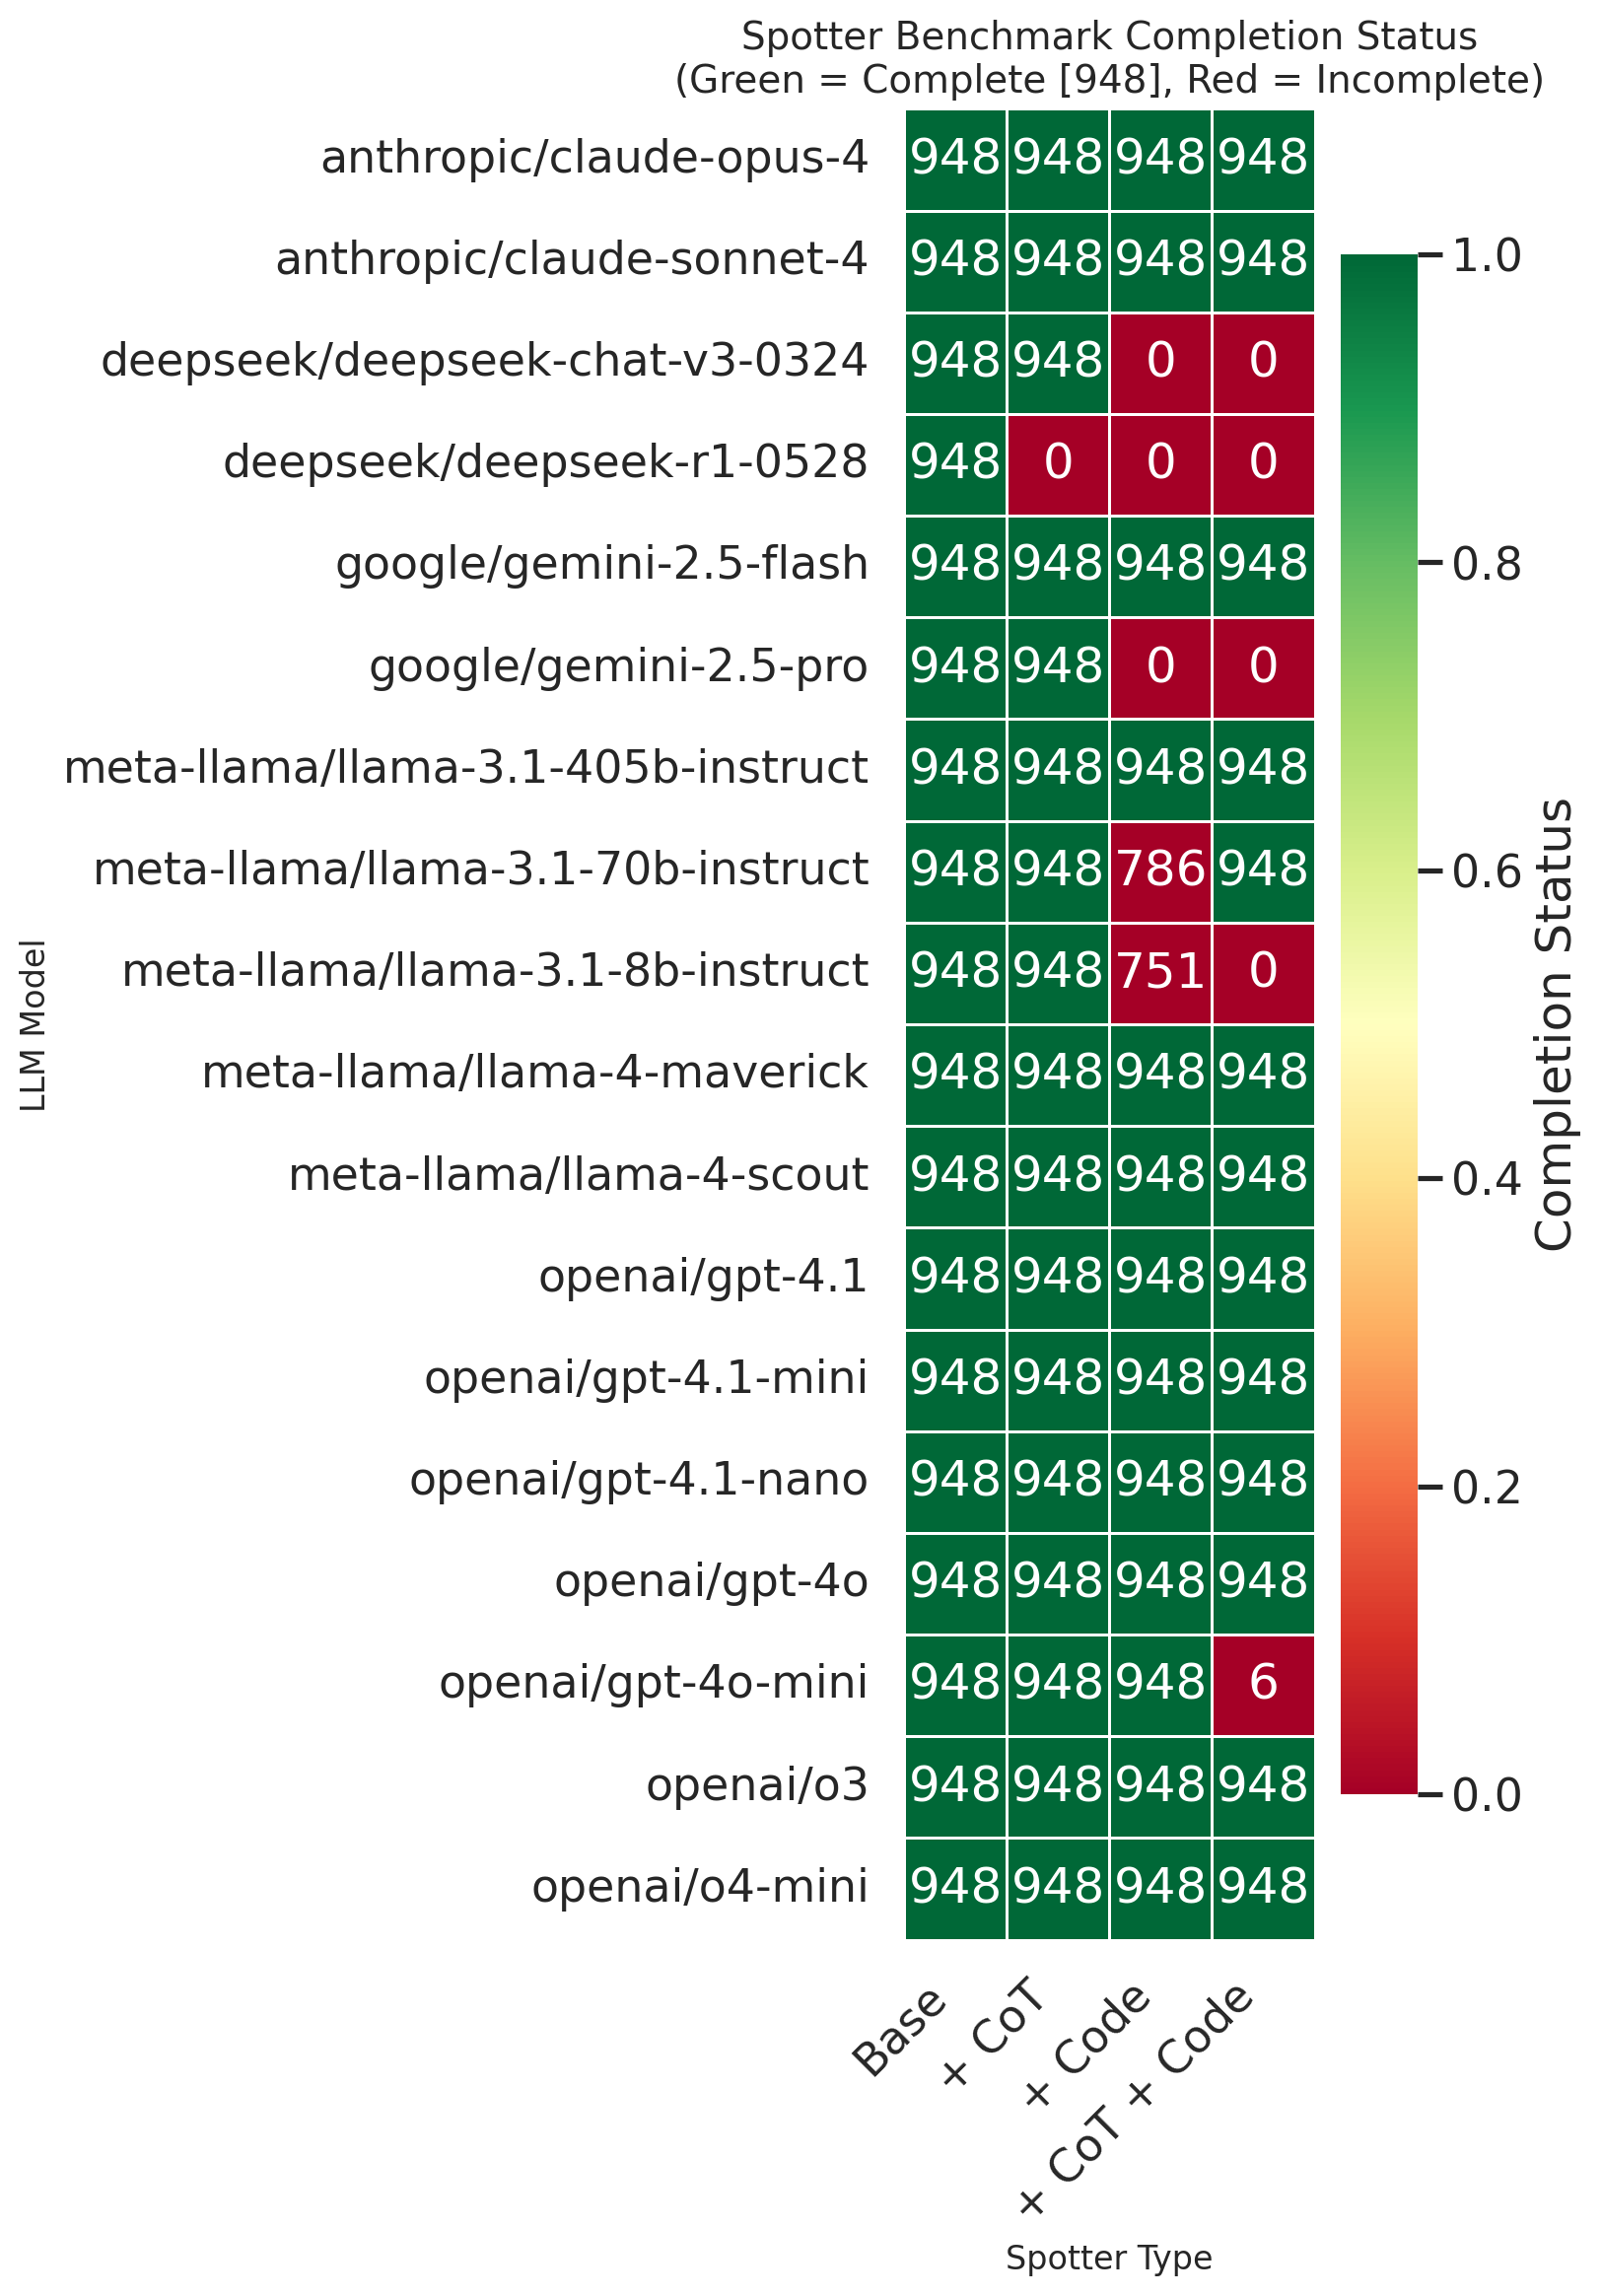

In [29]:
# Create a visualization of completion status
count_df = df.groupby(["llm", "spotter_type_short"], observed=False).size().to_frame(name="count")

# Create a pivot table for heatmap
pivot_df = count_df.reset_index().pivot(index="llm", columns="spotter_type_short", values="count")

# Create completion status (1 for complete, 0 for incomplete)
completion_df = (pivot_df == 948).astype(int)

# Create the heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(
    completion_df,
    annot=pivot_df,  # Show actual counts as annotations
    fmt='d',
    cmap='RdYlGn',
    cbar_kws={'label': 'Completion Status'},
    linewidths=0.5,
    linecolor='white'
)

plt.title('Spotter Benchmark Completion Status\n(Green = Complete [948], Red = Incomplete)', fontsize=14)
plt.xlabel('Spotter Type', fontsize=12)
plt.ylabel('LLM Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Answer value distribution

<Axes: xlabel='answer_text'>

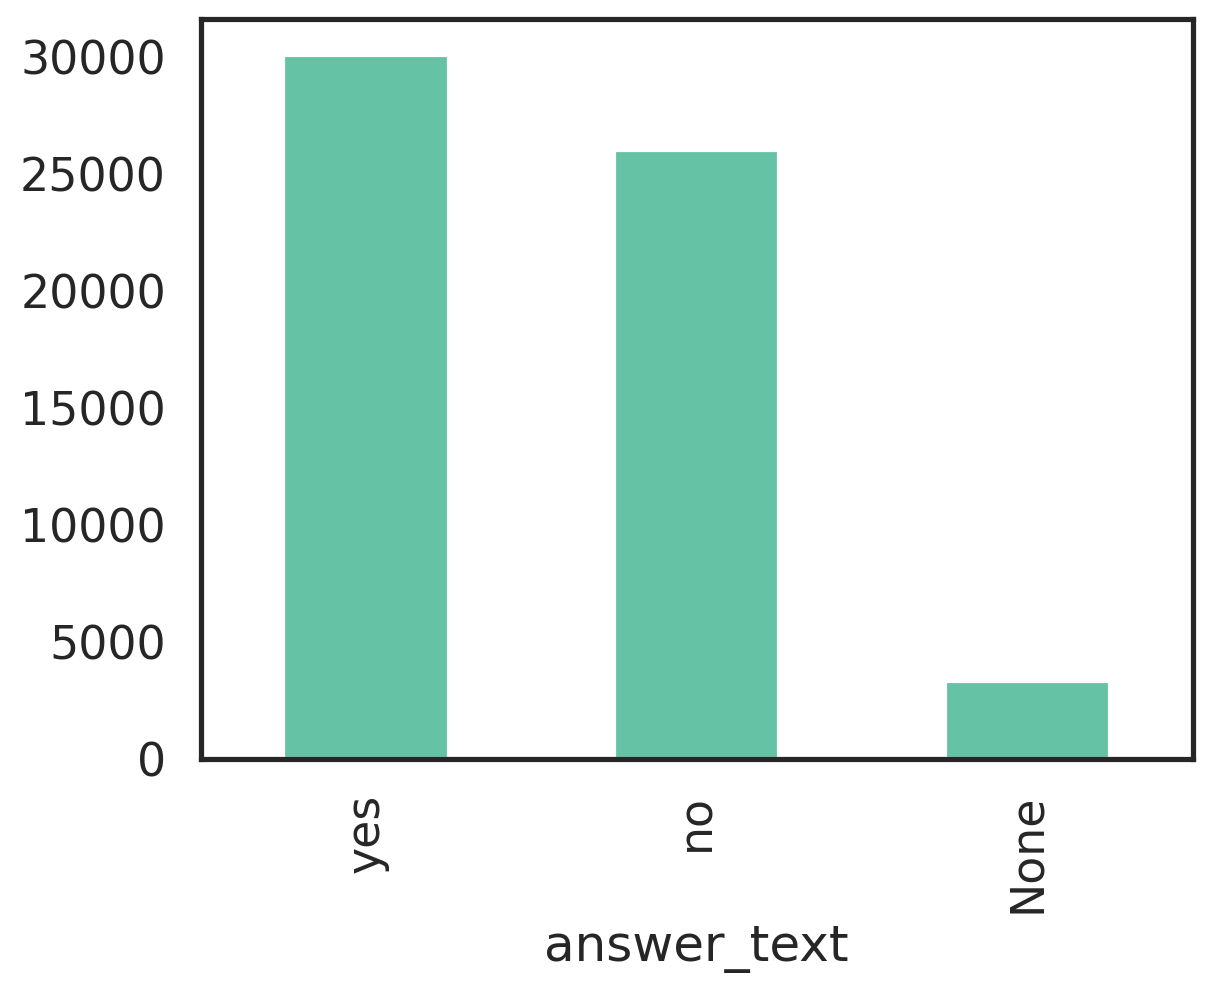

In [30]:
# Check distribution of raw answer text
df["answer_text"].value_counts(dropna=False).plot(kind="bar")

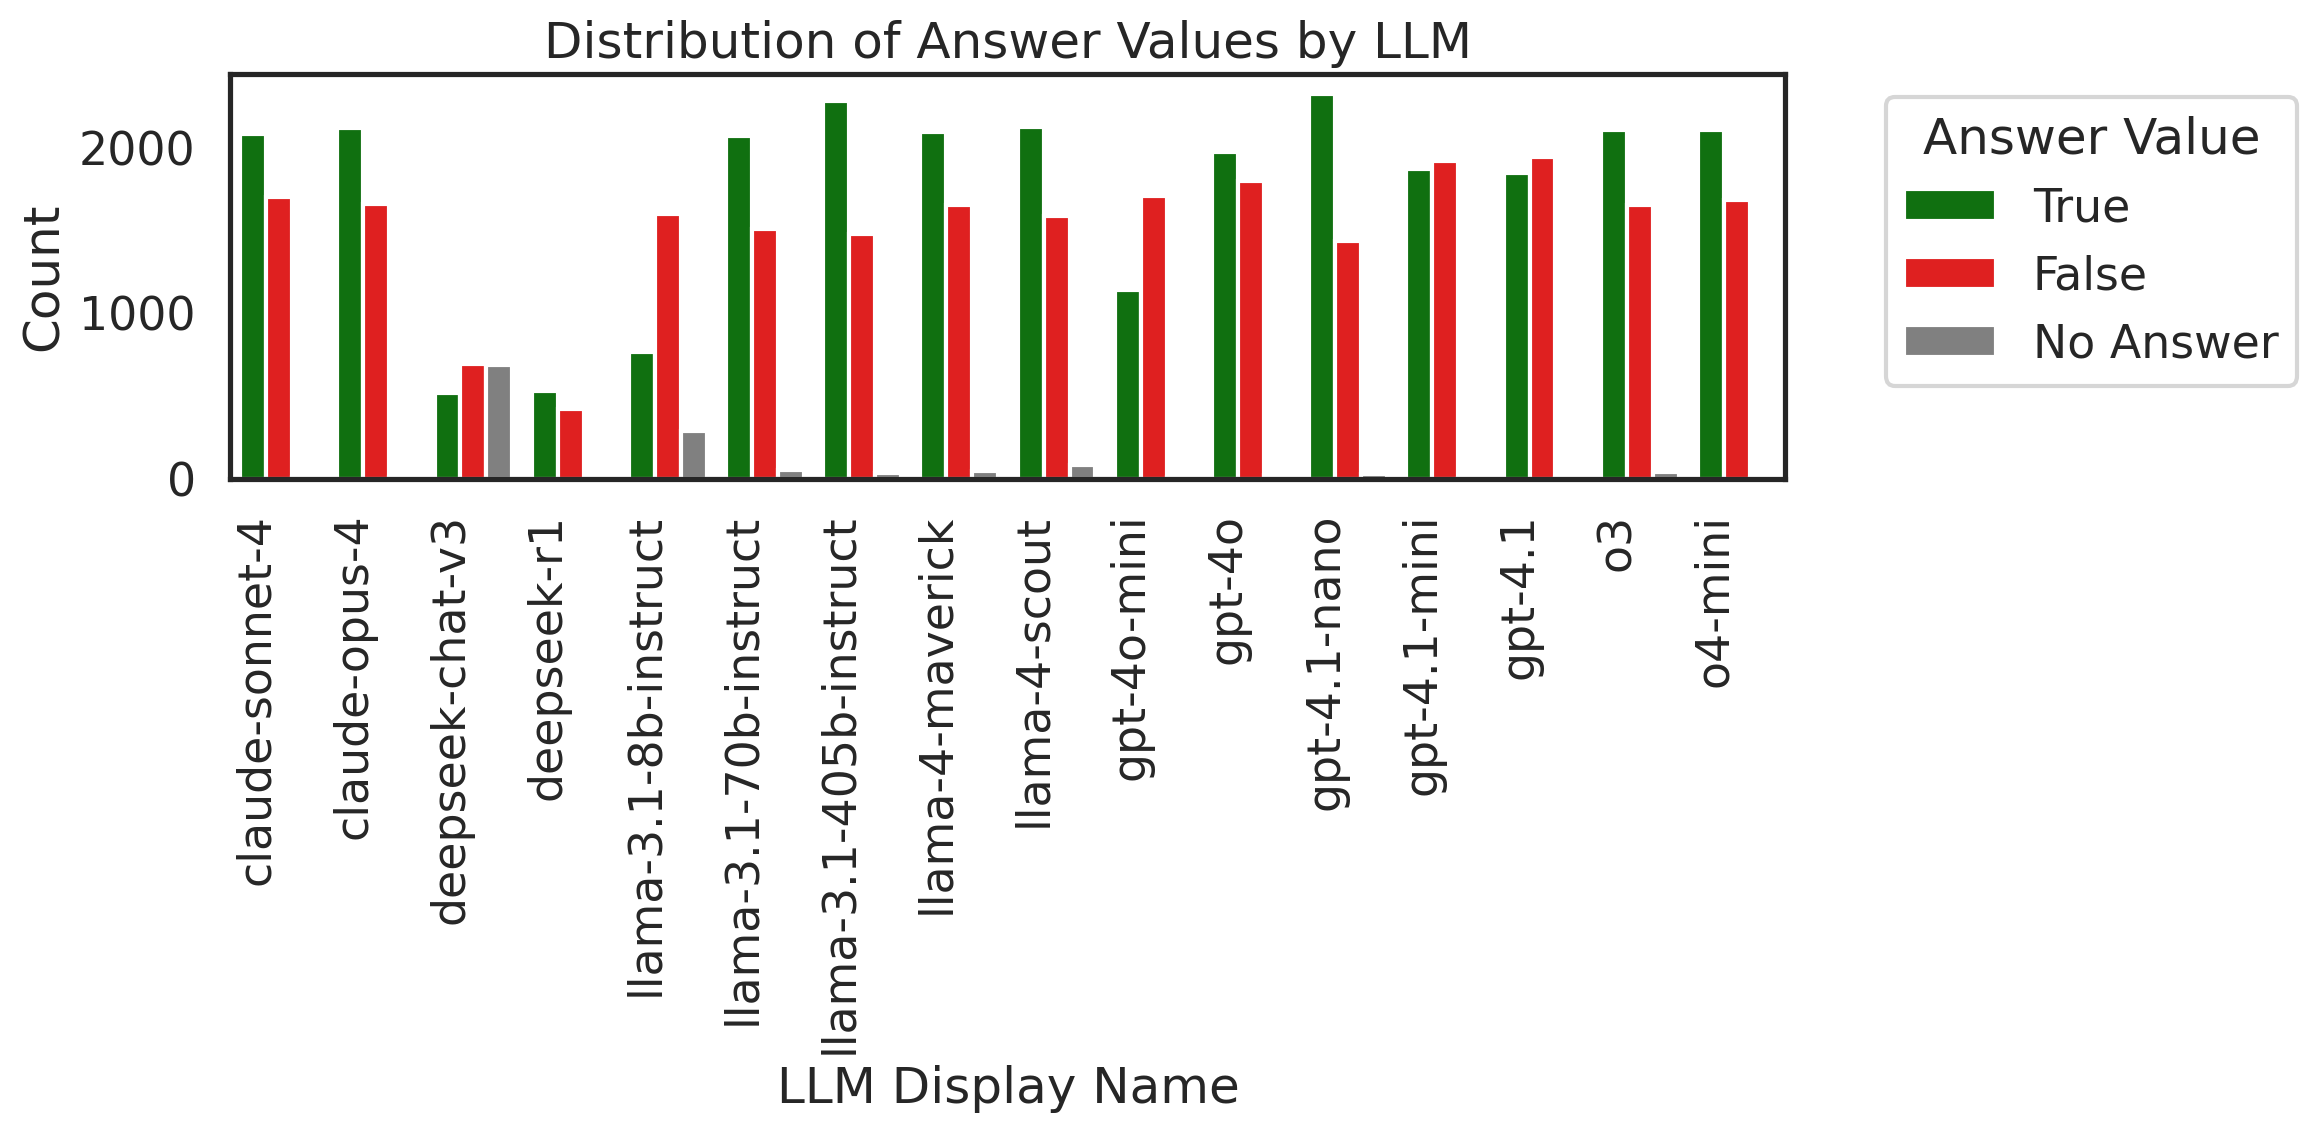

In [31]:
# Create a copy of the dataframe and handle None values in answer_value
df_plot = df.copy()
df_plot["answer_value"] = df_plot["answer_value"].fillna("No Answer")

# Visualize the distribution of answer values by LLM and spotter type
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_plot,
    x="llm_display_name",
    hue="answer_value",
    order=df["llm_display_name"].cat.categories,
    palette={True: "green", False: "red", "No Answer": "gray"}
)

plt.title("Distribution of Answer Values by LLM")
plt.xlabel("LLM Display Name")
plt.ylabel("Count")
plt.xticks(rotation=90, ha="right")
plt.legend(title="Answer Value", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Accuracy

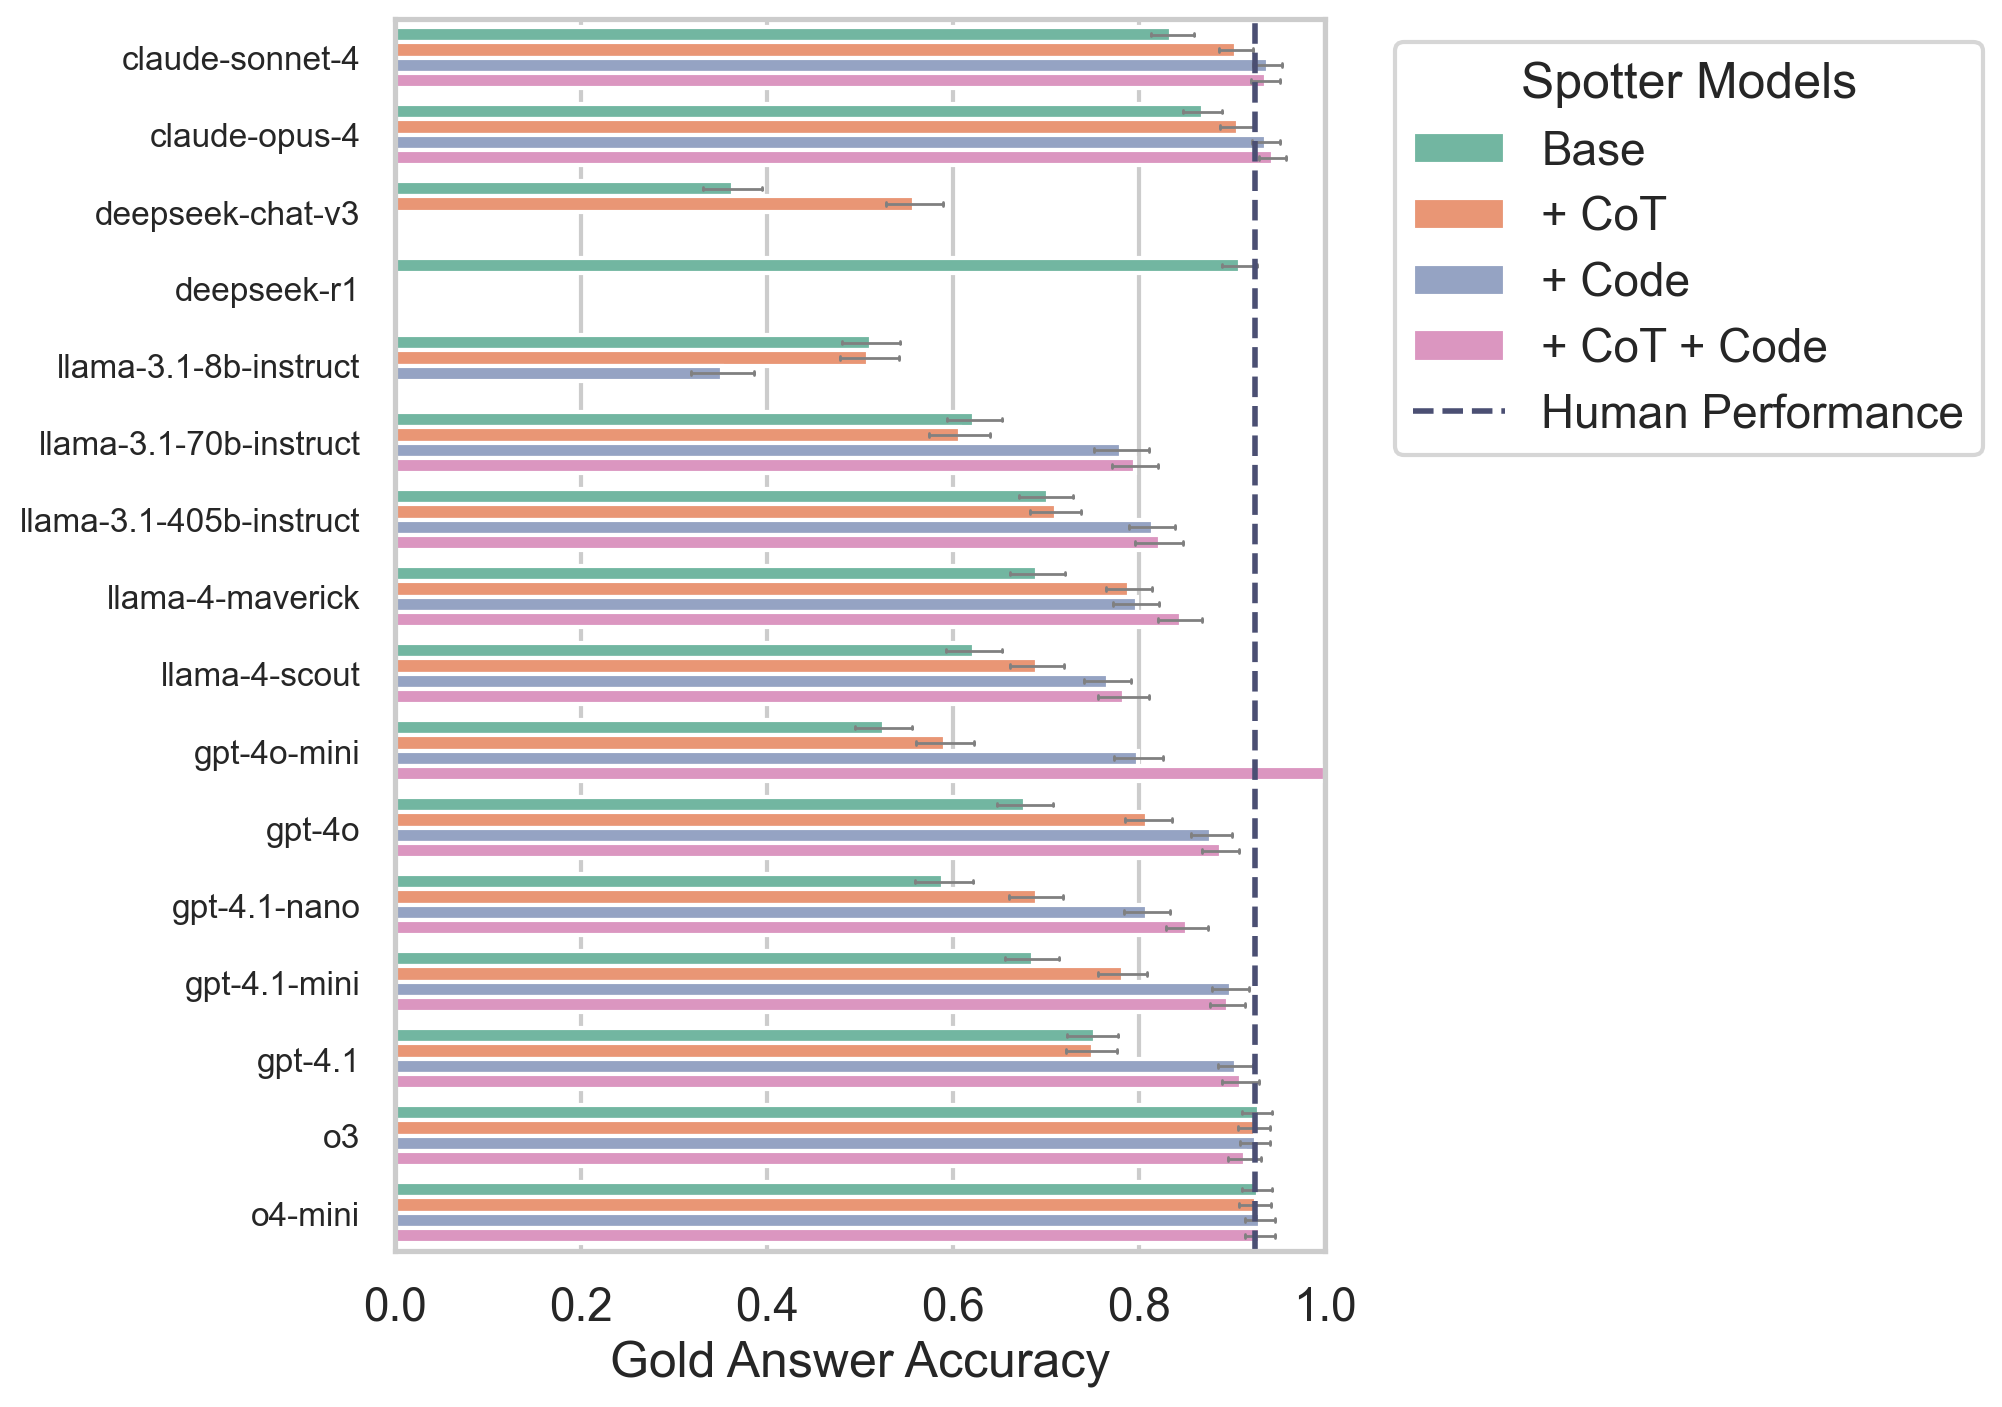

In [32]:
with sns.plotting_context(context="talk"), sns.axes_style("whitegrid"):

    plt.figure(figsize=(6, 8))
    sns.barplot(
        data=df,
        x="is_correct",
        y="llm_display_name",
        hue="spotter_type_short",
        errorbar=("ci", 95),
        err_kws={
            "color": "gray",
            "linewidth": 1,
        },
        capsize=0.2,
    )

    plt.axvline(
        human_accuracy_baseline,
        color="#4b4f73",
        linestyle="--",
        linewidth=2.0,
        label="Human Performance",
    )

    plt.ylabel("")
    plt.xlabel("Gold Answer Accuracy")

    plt.xlim(0.0, 1.0)

    plt.yticks(fontsize=12)

    plt.legend(title="Spotter Models", bbox_to_anchor=(1.05, 1), loc='upper left')

    # plt.savefig(
    #     os.path.join(PATH_EXPORT, "spotter_accuracy.pdf"),
    #     bbox_inches="tight",
    #     dpi=300,
    # )

### Spotter Type Performance Across All Models

/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_11429/4170129702.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spotter_accuracy = df.groupby(["spotter_type_short", "llm_display_name"])["is_correct"].mean().reset_index()


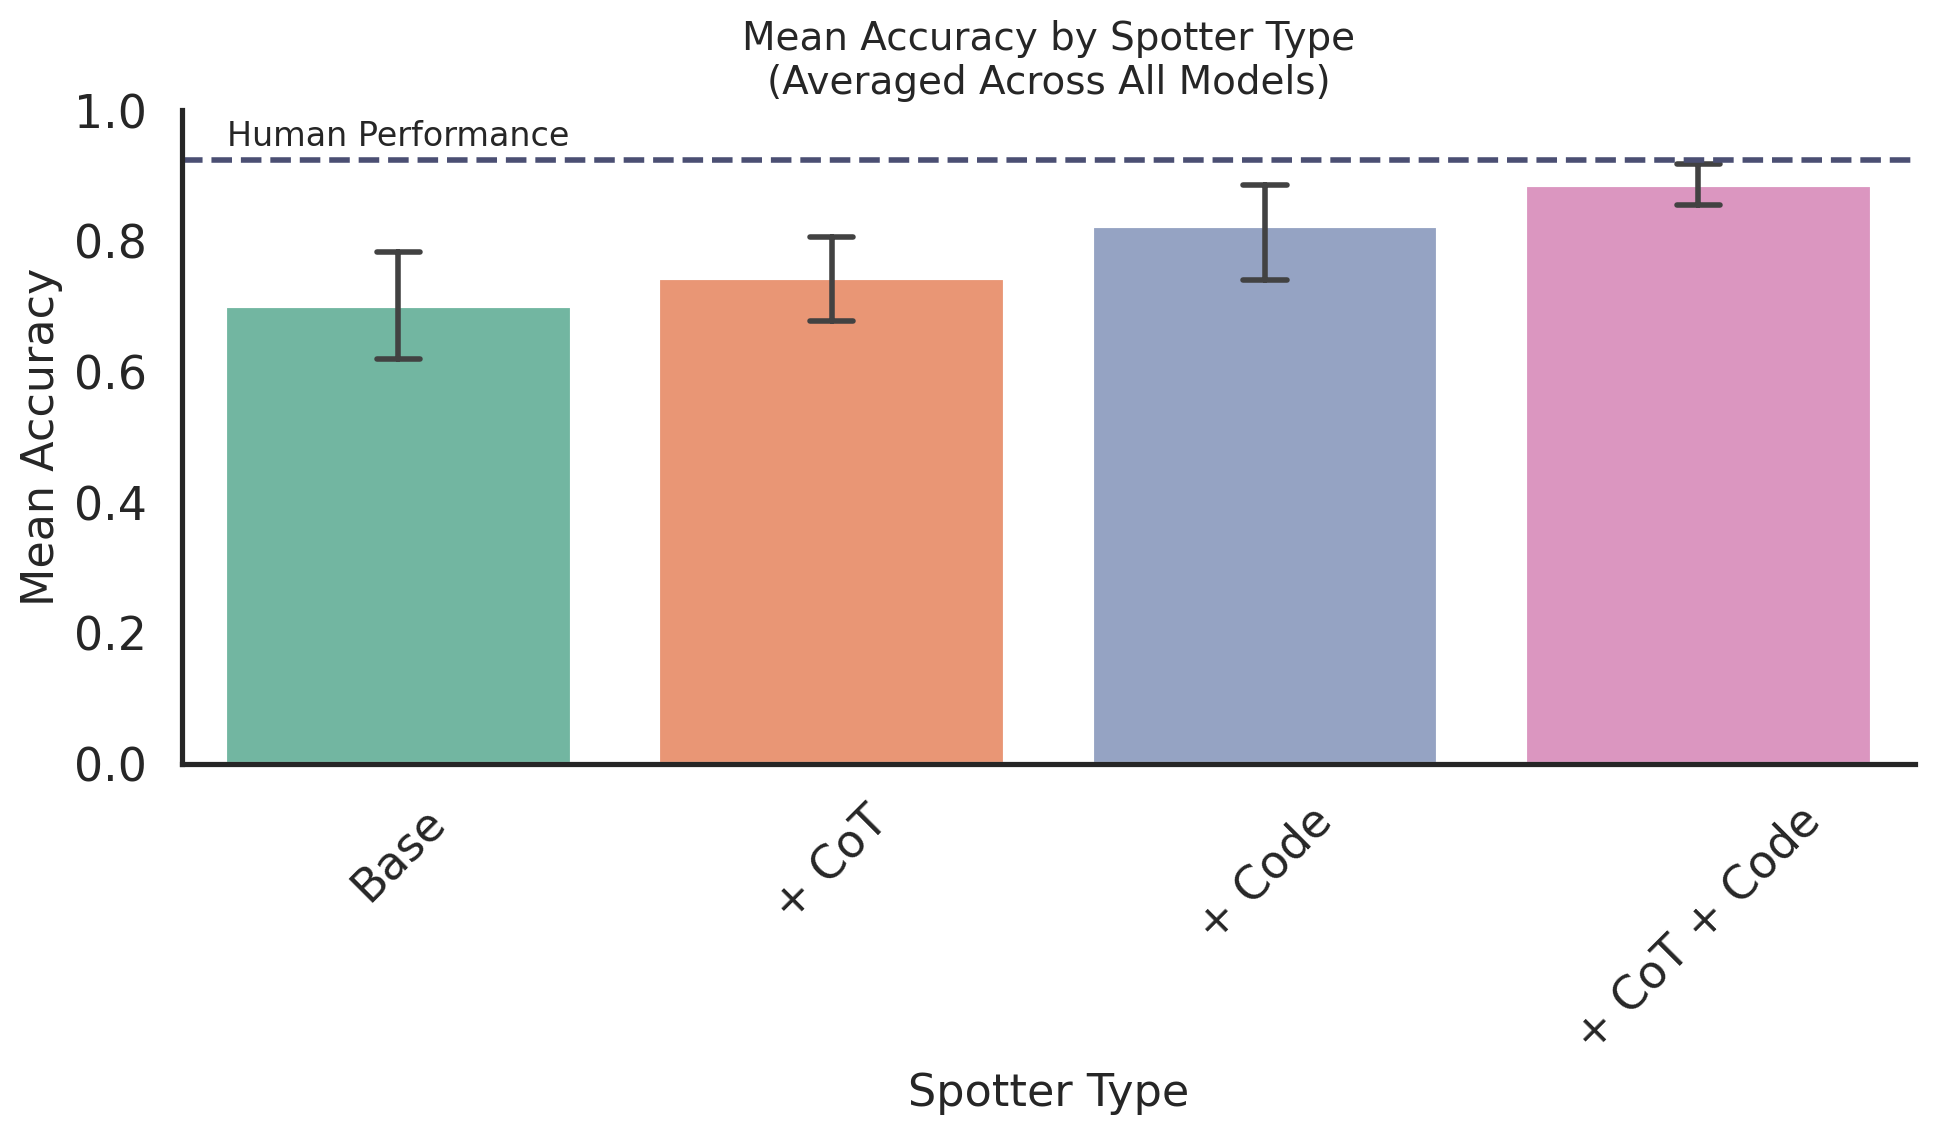

Summary Statistics by Spotter Type:
                    count   mean    std    min   max  mean_pct
spotter_type_short                                            
Base                17064  0.687  0.464  False  True      68.7
+ CoT               16116  0.742  0.438  False  True      74.2
+ Code              13861  0.804  0.397  False  True      80.4
+ CoT + Code        12330  0.847  0.360  False  True      84.7


/var/folders/sh/8jsdb_2j3vn036t4v06sbxdh0000gn/T/ipykernel_11429/4170129702.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spotter_stats = df.groupby("spotter_type_short")["is_correct"].agg([


In [33]:
# Bar plot showing mean accuracy with confidence intervals for each spotter type
# Calculate mean accuracy for each spotter type across all models
spotter_accuracy = df.groupby(["spotter_type_short", "llm_display_name"])["is_correct"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=spotter_accuracy,
    x="spotter_type_short",
    y="is_correct",
    hue="spotter_type_short",
    errorbar=("ci", 95),
    err_kws={
        "linewidth": 2,
    },
    capsize=0.1,
)
plt.axhline(
    human_accuracy_baseline,
    color="#4b4f73",
    linestyle="--",
    linewidth=2.0,
    label="Human Performance"
)
plt.text(
    s="Human Performance",
    x=0.0,
    y=human_accuracy_baseline + 0.01,
    fontsize=12,
    ha="center",
    va="bottom",
)
plt.title("Mean Accuracy by Spotter Type\n(Averaged Across All Models)", fontsize=14)
plt.xlabel("Spotter Type", fontsize=16)
plt.ylabel("Mean Accuracy", fontsize=16)
plt.ylim(0, 1.0)
# plt.legend()
plt.xticks(rotation=45)

sns.despine()

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics by Spotter Type:")
print("=" * 50)
spotter_stats = df.groupby("spotter_type_short")["is_correct"].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
spotter_stats['mean_pct'] = (spotter_stats['mean'] * 100).round(1)
print(spotter_stats)

In [34]:
# Pairwise statistical significance testing between spotter types
from scipy import stats
from itertools import combinations
import pandas as pd

print("Pairwise Statistical Comparisons (Mann-Whitney U Test):")
print("=" * 60)

# Get all spotter types
spotter_types = df["spotter_type_short"].cat.categories

# Create a results table for p-values
results_data = []

# Perform pairwise comparisons
for type1, type2 in combinations(spotter_types, 2):
    # Get accuracy data for each spotter type
    data1 = df[df["spotter_type_short"] == type1]["is_correct"]
    data2 = df[df["spotter_type_short"] == type2]["is_correct"]

    # Perform Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')

    # Calculate means and effect size
    mean1 = data1.mean()
    mean2 = data2.mean()
    mean_diff = mean2 - mean1

    # Determine significance level
    if p_value < 0.001:
        significance = "***"
        sig_level = "p < 0.001"
    elif p_value < 0.01:
        significance = "**"
        sig_level = "p < 0.01"
    elif p_value < 0.05:
        significance = "*"
        sig_level = "p < 0.05"
    else:
        significance = ""
        sig_level = "n.s."

    # Store results
    results_data.append({
        'Comparison': f"{type1} vs {type2}",
        'Mean_1': mean1,
        'Mean_2': mean2,
        'Difference': mean_diff,
        'P_value': p_value,
        'Significance': significance,
        'Sig_Level': sig_level
    })

    # Print detailed results
    print(f"{type1} vs {type2}:")
    print(f"  Mean accuracy: {mean1:.3f} vs {mean2:.3f} (diff: {mean_diff:+.3f})")
    print(f"  Sample sizes: {len(data1)} vs {len(data2)}")
    print(f"  p-value: {p_value:.4f} {significance} ({sig_level})")
    print()

# Create a summary table
results_df = pd.DataFrame(results_data)
print("\nSummary Table of Pairwise Comparisons:")
print("=" * 60)
print(results_df.round(4).to_string(index=False))


Pairwise Statistical Comparisons (Mann-Whitney U Test):
Base vs + CoT:
  Mean accuracy: 0.687 vs 0.742 (diff: +0.054)
  Sample sizes: 17064 vs 16116
  p-value: 0.0000 *** (p < 0.001)

Base vs + Code:
  Mean accuracy: 0.687 vs 0.804 (diff: +0.117)
  Sample sizes: 17064 vs 13861
  p-value: 0.0000 *** (p < 0.001)

Base vs + CoT + Code:
  Mean accuracy: 0.687 vs 0.847 (diff: +0.160)
  Sample sizes: 17064 vs 12330
  p-value: 0.0000 *** (p < 0.001)

+ CoT vs + Code:
  Mean accuracy: 0.742 vs 0.804 (diff: +0.063)
  Sample sizes: 16116 vs 13861
  p-value: 0.0000 *** (p < 0.001)

+ CoT vs + CoT + Code:
  Mean accuracy: 0.742 vs 0.847 (diff: +0.106)
  Sample sizes: 16116 vs 12330
  p-value: 0.0000 *** (p < 0.001)

+ Code vs + CoT + Code:
  Mean accuracy: 0.804 vs 0.847 (diff: +0.043)
  Sample sizes: 13861 vs 12330
  p-value: 0.0000 *** (p < 0.001)


Summary Table of Pairwise Comparisons:
            Comparison  Mean_1  Mean_2  Difference  P_value Significance Sig_Level
         Base vs + CoT  0.

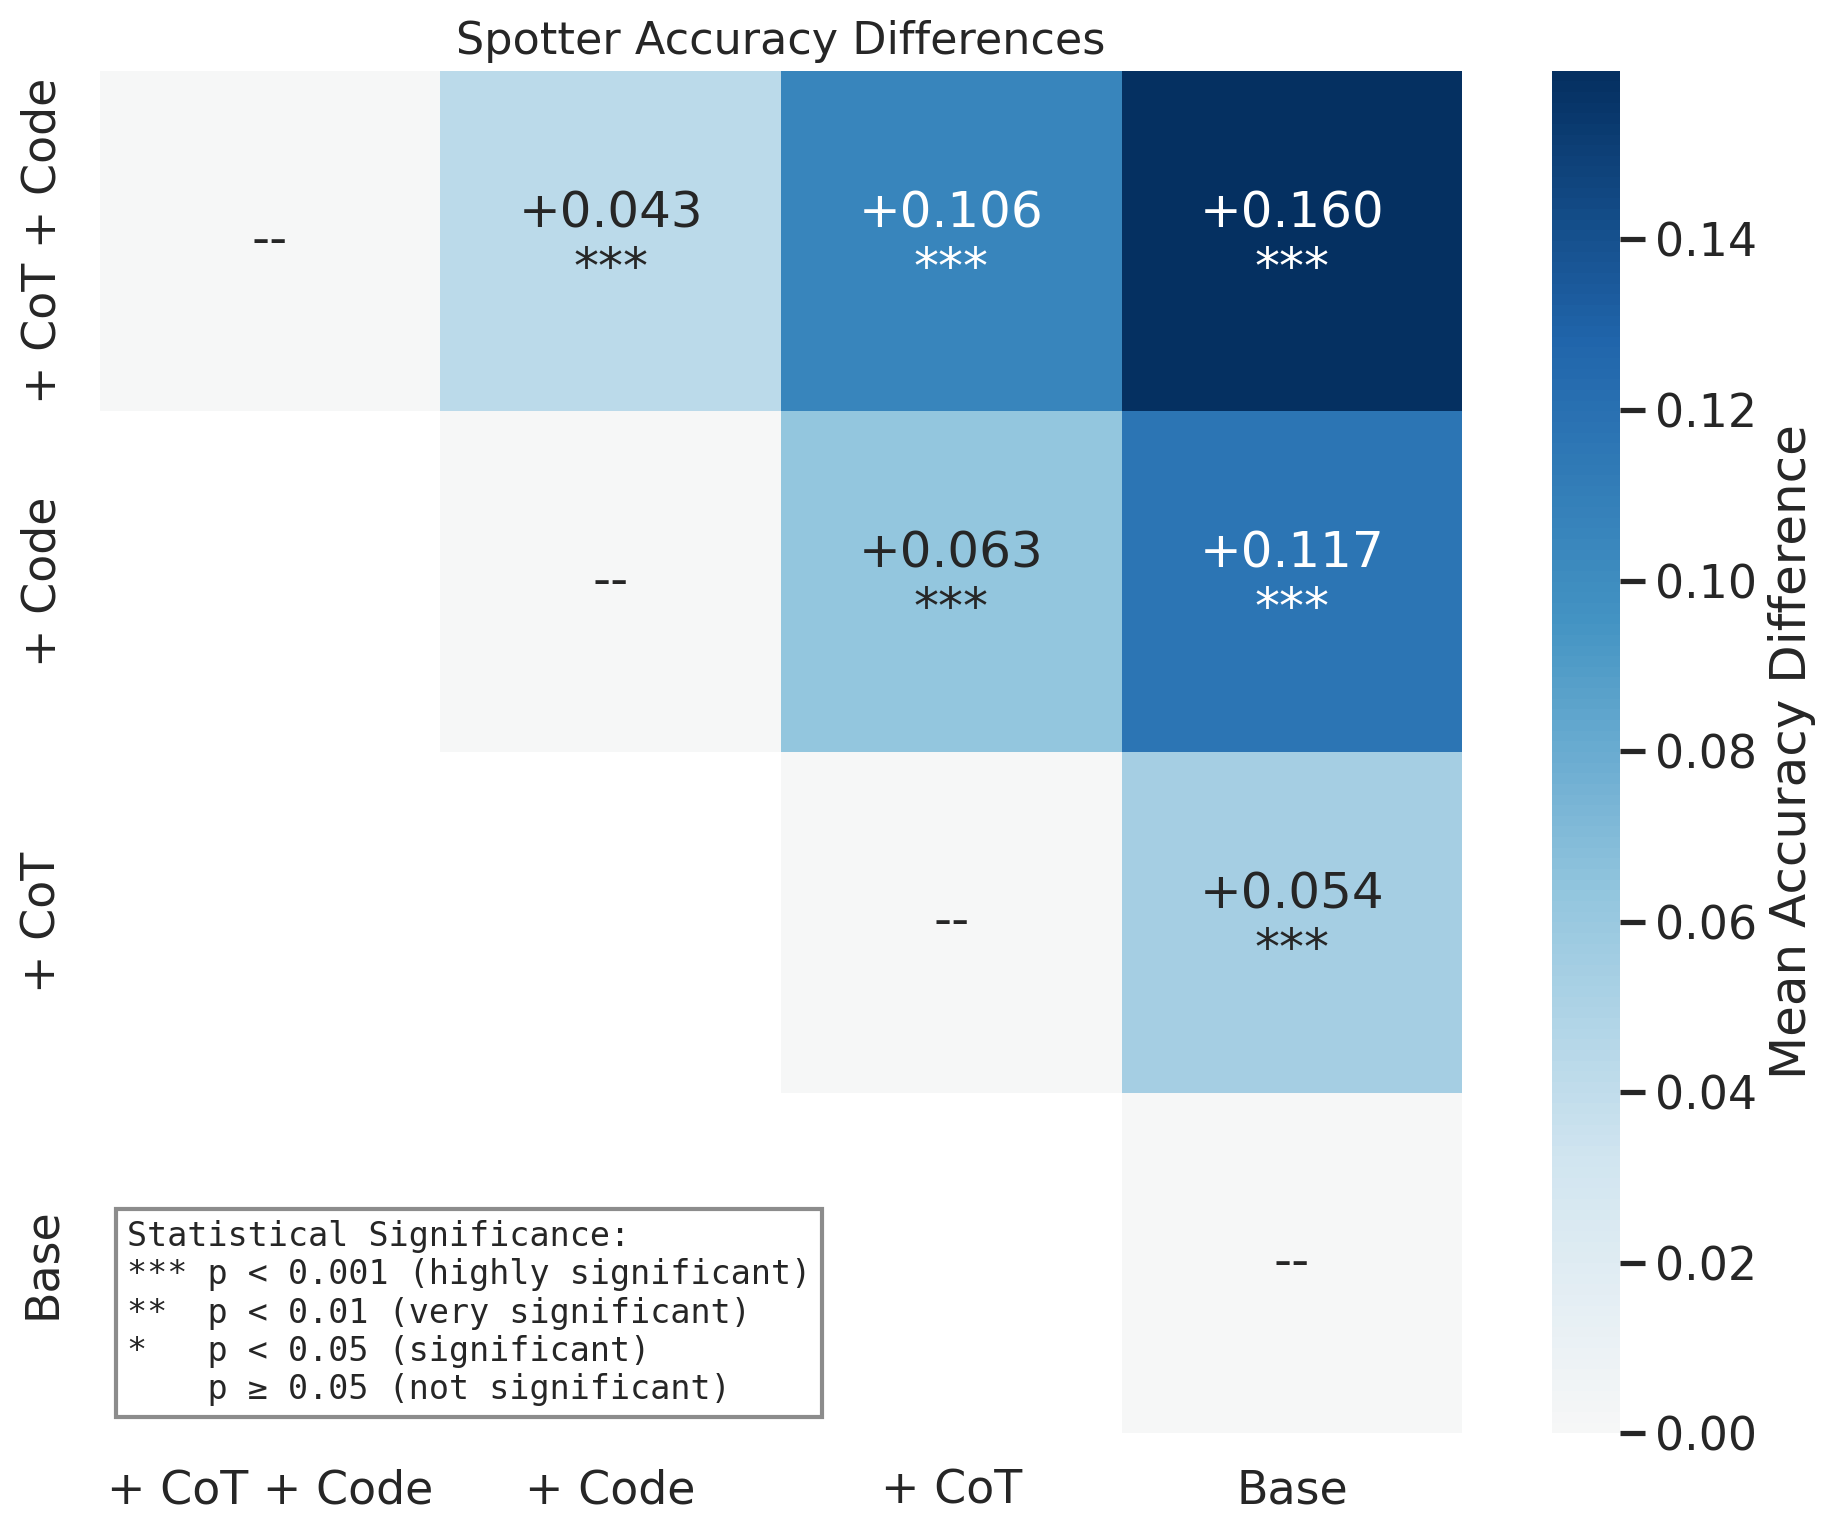

In [35]:
# Create matrices for significance analysis
n_types = len(spotter_types)
significance_matrix = np.full((n_types, n_types), "", dtype=object)
mean_diff_matrix = np.zeros((n_types, n_types))

# Fill the matrices
for i, type1 in enumerate(spotter_types):
    for j, type2 in enumerate(spotter_types):
        if i != j:  # Don't compare a type with itself
            # Find the comparison in our results
            comparison1 = f"{type1} vs {type2}"
            comparison2 = f"{type2} vs {type1}"

            # Find the result (either direction)
            result = results_df[
                (results_df['Comparison'] == comparison1) |
                (results_df['Comparison'] == comparison2)
            ]

            if not result.empty:
                sig = result.iloc[0]['Significance']
                significance_matrix[i, j] = sig

                # Use the difference from the perspective of j vs i (column vs row)
                if result.iloc[0]['Comparison'] == comparison2:
                    mean_diff_matrix[i, j] = result.iloc[0]['Difference']
                else:
                    mean_diff_matrix[i, j] = -result.iloc[0]['Difference']

# Reverse the order of spotter types (flip rows and columns)
spotter_types_reversed = spotter_types[::-1]

# Create reversed indices mapping
reverse_idx = {i: n_types - 1 - i for i in range(n_types)}

# Create new matrices with reversed order
mean_diff_matrix_rev = np.zeros((n_types, n_types))
significance_matrix_rev = np.full((n_types, n_types), "", dtype=object)

for i in range(n_types):
    for j in range(n_types):
        rev_i = reverse_idx[i]
        rev_j = reverse_idx[j]
        mean_diff_matrix_rev[i, j] = mean_diff_matrix[rev_i, rev_j]
        significance_matrix_rev[i, j] = significance_matrix[rev_i, rev_j]

# Create annotations that combine significance and mean difference
annotations = np.full((n_types, n_types), "", dtype=object)
for i in range(n_types):
    for j in range(n_types):
        if i == j:
            # Diagonal indicator - show the spotter type name
            annotations[i, j] = f"--"
        else:
            sig = significance_matrix_rev[i, j]
            diff = mean_diff_matrix_rev[i, j]
            annotations[i, j] = f"{diff:+.3f}\n{sig}" if sig else f"{diff:+.3f}"

# Create a mask for the lower triangle (excluding diagonal to preserve it)
mask = np.tril(np.ones_like(mean_diff_matrix_rev, dtype=bool), k=-1)

# Create the figure with more space for the legend
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Create the upper-triangular heatmap
sns.heatmap(
    mean_diff_matrix_rev,
    mask=mask,
    annot=annotations,
    fmt='',
    xticklabels=spotter_types_reversed,
    yticklabels=spotter_types_reversed,
    cmap='RdBu',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Mean Accuracy Difference'},
    square=True
)

ax.set_title("Spotter Accuracy Differences", fontsize=16)
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('', fontsize=12)

# Add legend text
legend_text = """Statistical Significance:
*** p < 0.001 (highly significant)
**  p < 0.01 (very significant)
*   p < 0.05 (significant)
    p ≥ 0.05 (not significant)"""

# Position the legend in the lower left corner of the plot
ax.text(0.02, 0.02, legend_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'), fontfamily='monospace')

plt.tight_layout()
plt.show()
